## Spark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
cur_path = "/content/drive"
os.listdir(cur_path)

['adult.csv']

In [ ]:
!pip install pyspark 
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
openjdk-8-jdk-headless is already the newest version (8u362-ga-0ubuntu1~20.04.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [ ]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[5]").appName('tree').getOrCreate()

In [ ]:
df = spark.read.format("csv").option("header","false").option("inferSchema" , "true").load(os.path.join(cur_path, 'adult.csv'))
raw_cols = "age|  workclass|fnlwgt|   education|education.num|marital.status|       occupation|  relationship| race|   sex|capital.gain|capital.loss|hours.per.week|native.country|income".split("|")
raw_cols = [x.strip().replace('.','_') for x in raw_cols]
for i in range(len(raw_cols)):
    df = df.withColumnRenamed(f"_c{i}", raw_cols[i])

### Pandas

In [ ]:
#df_pd = pd.read_csv("../../../data/p_dsi/big_data_scaling_sp23/project/DT-MapReduce/adult.csv").clean_names()
df_pd = df.toPandas()

In [ ]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from pandas.api.types import is_categorical_dtype
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from skopt import BayesSearchCV
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler, Normalizer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_pd.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income'],
      dtype='object')

In [ ]:
df_pd["marital_relation"] = df_pd["marital_status"] + "_" + df_pd["relationship"]
df_pd = df_pd.drop(["sex","race","education_num", "native_country", "marital_status","relationship"], axis = 1)

In [ ]:
df_pd["income"].unique()

array([' <=50K', ' >50K'], dtype=object)

In [ ]:
df_pd["income"] = np.where(df_pd.income==' <=50K', 0, 1)

In [ ]:
df_pd["income"].unique()

array([0, 1])

### Feature Engineering

In [ ]:
pd_new = pd.get_dummies(df_pd.drop_duplicates())

In [ ]:
pd_new.shape

(32536, 75)

In [ ]:
X, y = pd_new.drop('income', axis=1), pd_new.income

In [ ]:
X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.2, random_state=1)

### Training

In [ ]:
# ct = ColumnTransformer([("ohe", OneHotEncoder(handle_unknown="ignore"), stri), ("ord", ordi, ["education"]), ("min_max", MinMaxScaler(), num)])
# Tree based model don't have to be normalized

In [ ]:
dt = DecisionTreeClassifier(criterion="entropy")

In [ ]:
import numpy as np
max_features = list(np.arange(3,20))
max_depth = list(np.arange(3,20))

In [ ]:
param_grid = [{"max_features":max_features, "max_depth": max_depth}]

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
bayes_search = BayesSearchCV(dt, param_grid, cv = 5, n_iter = 30)

In [ ]:
bayes_search.fit(X_train, y_train);

In [ ]:
bayes_search.best_params_

OrderedDict([('max_depth', 12), ('max_features', 15)])

In [ ]:
bayes_search.best_score_

0.8403502681973338

In [ ]:
result = pd.DataFrame(bayes_search.cv_results_).sort_values("rank_test_score", ascending = True)

In [ ]:
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
20,0.031603,0.011805,0.005707,0.001569,12,15,"{'max_depth': 12, 'max_features': 15}",0.843318,0.838710,0.839478,0.840123,0.840123,0.840350,0.001572,1
22,0.020236,0.004380,0.004691,0.001238,12,15,"{'max_depth': 12, 'max_features': 15}",0.844854,0.826421,0.852535,0.838586,0.829362,0.838351,0.009661,2
18,0.018724,0.003121,0.004313,0.000571,11,11,"{'max_depth': 11, 'max_features': 11}",0.827189,0.819508,0.838710,0.833974,0.841660,0.832208,0.008015,3
23,0.020061,0.004099,0.004228,0.000572,12,11,"{'max_depth': 12, 'max_features': 11}",0.824885,0.831797,0.843318,0.831668,0.828593,0.832052,0.006172,4
27,0.018638,0.002594,0.004447,0.000747,14,9,"{'max_depth': 14, 'max_features': 9}",0.836406,0.834869,0.827189,0.820138,0.840892,0.831899,0.007355,5
26,0.020192,0.004063,0.004168,0.000549,14,15,"{'max_depth': 14, 'max_features': 15}",0.837942,0.836406,0.817972,0.840892,0.823213,0.831285,0.009002,6
6,0.070762,0.010903,0.013744,0.007768,14,11,"{'max_depth': 14, 'max_features': 11}",0.841782,0.835637,0.827957,0.829362,0.820138,0.830975,0.007317,7
2,0.032964,0.023211,0.006799,0.002973,6,15,"{'max_depth': 6, 'max_features': 15}",0.849462,0.831797,0.814900,0.829362,0.815527,0.828210,0.012680,8
10,0.019430,0.001786,0.004393,0.000568,14,8,"{'max_depth': 14, 'max_features': 8}",0.814132,0.830261,0.826421,0.833974,0.828593,0.826676,0.006741,9
9,0.096446,0.022484,0.026936,0.009529,16,9,"{'max_depth': 16, 'max_features': 9}",0.830261,0.829493,0.821813,0.825519,0.823213,0.826060,0.003343,10


In [ ]:
model = bayes_search.best_estimator_

In [ ]:
model

DecisionTreeClassifier(criterion='entropy', max_depth=12, max_features=15)

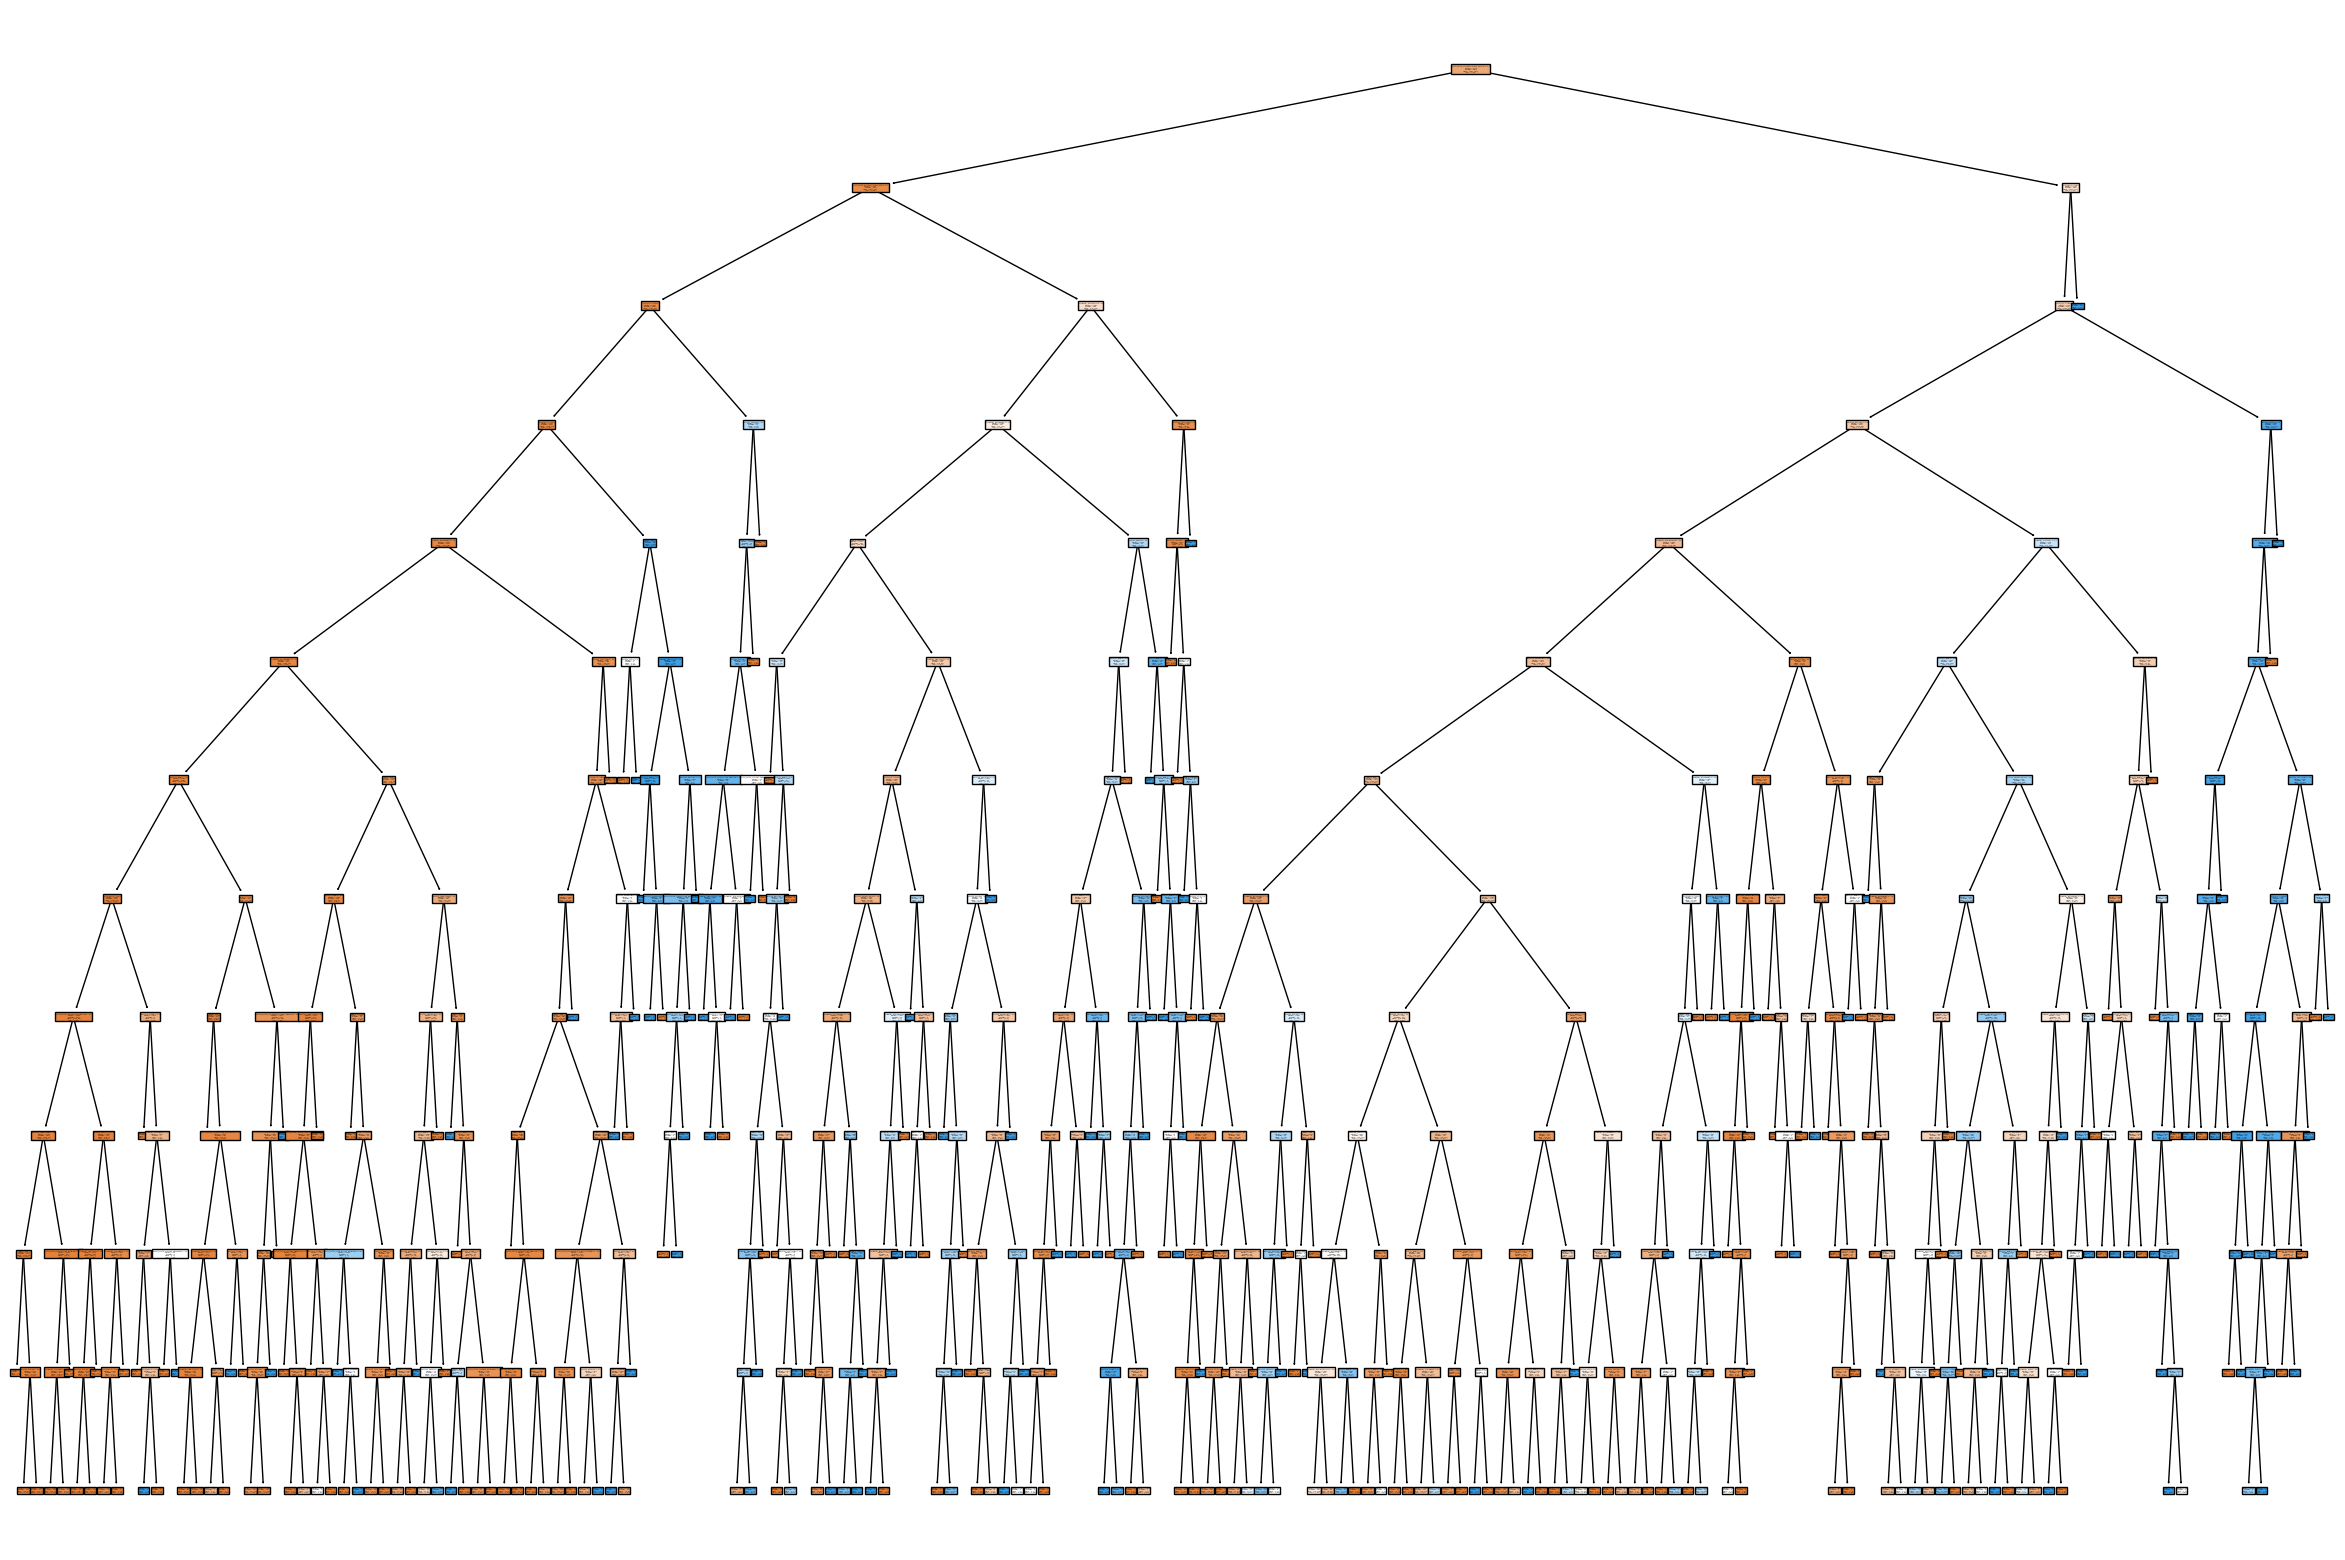

In [ ]:
from sklearn import tree
fig = plt.figure(figsize=(30,20))
_ = tree.plot_tree(model, 
                   feature_names= X.columns,  
                   class_names=["<=50K", ">50K"],
                   filled=True)

In [ ]:
#text_representation = tree.export_text(model[1])
#print(text_representation)

In [ ]:
pred = model.predict(X_test)

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90     19690
           1       0.73      0.51      0.60      6338

    accuracy                           0.84     26028
   macro avg       0.80      0.73      0.75     26028
weighted avg       0.83      0.84      0.83     26028



In [ ]:
conf = confusion_matrix(y_test,pred)

<Axes: >

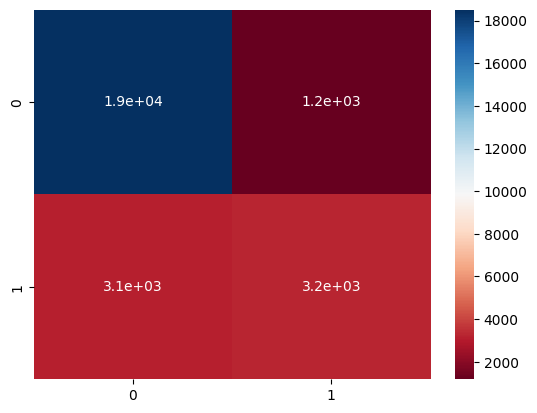

In [ ]:
sns.heatmap(conf, annot = True, cmap = "RdBu")

### Feature Importance

In [ ]:
fi = model.feature_importances_

In [ ]:
features = pd.DataFrame({'feat_names': X.columns, 'feat_importance': fi})

features = features.assign(magnitude = abs(features['feat_importance']), sign = np.sign(features['feat_importance']))

features = features.set_index('feat_names').sort_values(by='magnitude', ascending=False)
features.head(20)

,feat_importance,magnitude,sign
feat_names,,,
marital_relation_ Married-civ-spouse_ Husband,0.267075,0.267075,1.0
capital_gain,0.202883,0.202883,1.0
age,0.085370,0.085370,1.0
marital_relation_ Married-civ-spouse_ Wife,0.068346,0.068346,1.0
hours_per_week,0.061936,0.061936,1.0
capital_loss,0.055743,0.055743,1.0
fnlwgt,0.042738,0.042738,1.0
education_ Bachelors,0.033844,0.033844,1.0
occupation_ Exec-managerial,0.028768,0.028768,1.0


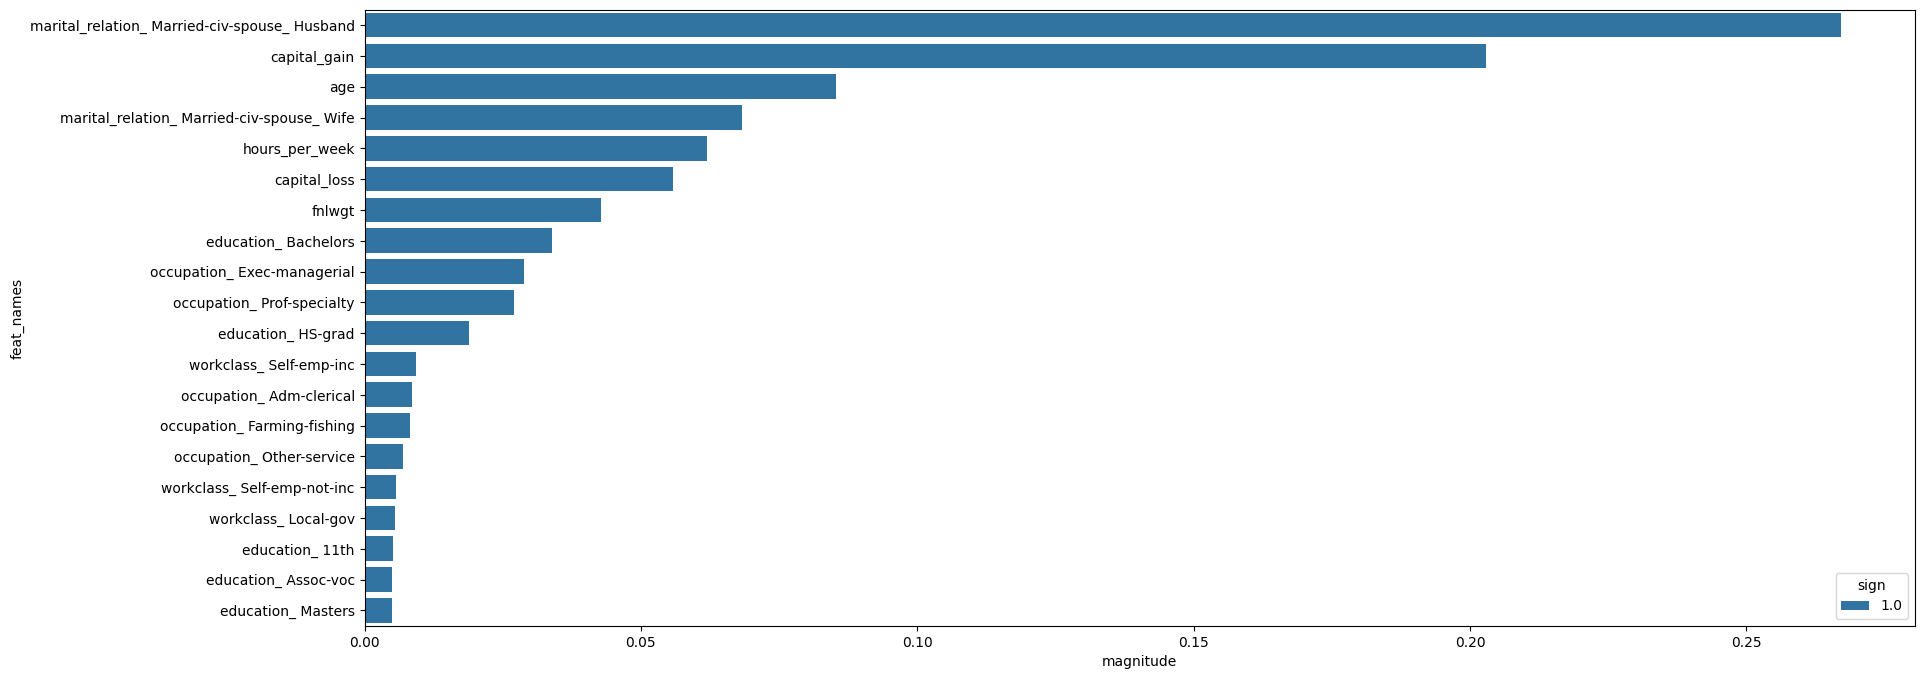

In [ ]:
plt.figure(figsize = (20,8))
sns.barplot(y=features.index[:20], x='magnitude', hue='sign', data=features[:20], orient='h', dodge=False);

In [ ]:
important_features = features.iloc[:15].index.tolist()
important_features

['marital_relation_ Married-civ-spouse_ Husband',
 'capital_gain',
 'age',
 'marital_relation_ Married-civ-spouse_ Wife',
 'hours_per_week',
 'capital_loss',
 'fnlwgt',
 'education_ Bachelors',
 'occupation_ Exec-managerial',
 'occupation_ Prof-specialty',
 'education_ HS-grad',
 'workclass_ Self-emp-inc',
 'occupation_ Adm-clerical',
 'occupation_ Farming-fishing',
 'occupation_ Other-service']

In [ ]:
df_selected = X[important_features]

In [ ]:
df_selected['income'] = y

In [ ]:
df_selected.columns = [x.replace(' ','').replace('-','_') for x in df_selected.columns]

### Now let's use the selected features to build a decision tree from scatch with MapReduce

In [ ]:
from pyspark.sql.functions import col, count, when

In [ ]:
# Putting df_selected back to a spark df
df = spark.createDataFrame(df_selected)
df.printSchema()

root
 |-- marital_relation_Married_civ_spouse_Husband: long (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- age: long (nullable = true)
 |-- marital_relation_Married_civ_spouse_Wife: long (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education_Bachelors: long (nullable = true)
 |-- occupation_Exec_managerial: long (nullable = true)
 |-- occupation_Prof_specialty: long (nullable = true)
 |-- education_HS_grad: long (nullable = true)
 |-- workclass_Self_emp_inc: long (nullable = true)
 |-- occupation_Adm_clerical: long (nullable = true)
 |-- occupation_Farming_fishing: long (nullable = true)
 |-- occupation_Other_service: long (nullable = true)
 |-- income: long (nullable = true)



In [ ]:
train_fraction = 0.8
test_fraction = 0.2
random_seed = 0

train_data, test_data = df.randomSplit([train_fraction, test_fraction], seed=random_seed)

In [ ]:
def gini_impurity(dataframe, label_col):
    total_count = dataframe.count()
    class_counts = dataframe.groupBy(label_col).count().collect()
    impurity = 1.0

    for row in class_counts:
        p = row['count'] / total_count
        impurity -= p * p

    return impurity

def split_dataframe(dataframe, feature, value):
    left_split = dataframe.filter(col(feature) <= value)
    right_split = dataframe.filter(col(feature) > value)

    return left_split, right_split

def find_best_split(dataframe, label_col, features):
    best_gini = float('inf')
    best_feature = None
    best_value = None

    for feature in features:
        feature_values = dataframe.select(feature).toPandas()[feature].values
        if len(np.unique(feature_values)) == 2:
            feature_values = [0]
        else:
            feature_values = [np.quantile(feature_values, 0.5)]

        for value in feature_values:
            left_split, right_split = split_dataframe(dataframe, feature, value)

            left_gini = gini_impurity(left_split, label_col)
            right_gini = gini_impurity(right_split, label_col)

            split_gini = (left_split.count() * left_gini + right_split.count() * right_gini) / dataframe.count()

            if split_gini < best_gini:
                best_gini = split_gini
                best_feature = feature
                best_value = value

    return best_feature, best_value

In [ ]:
class DecisionTreeNode:
    def __init__(self, data, label_col, features, max_depth=5, min_samples_split=10, depth=0):
        self.data = data
        self.label_col = label_col
        self.features = features
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.depth = depth
        self.left = None
        self.right = None
        self.split_feature = None
        self.split_value = None

    def build_tree(self):
        majority_class_row = self.data.groupBy(self.label_col).count().orderBy("count", ascending=False).first()
        self.majority_class = majority_class_row[self.label_col]
        
        if self.depth >= self.max_depth or self.data.count() < self.min_samples_split:
            self.data = None  # Detach the data from the node
            return

        best_split = find_best_split(self.data, self.label_col, self.features)

        if not best_split:
            return

        self.split_feature, self.split_value = best_split

        left_data, right_data = split_dataframe(self.data, self.split_feature, self.split_value)

        self.left = DecisionTreeNode(left_data, self.label_col, self.features, self.max_depth, self.min_samples_split, self.depth + 1)
        self.right = DecisionTreeNode(right_data, self.label_col, self.features, self.max_depth, self.min_samples_split, self.depth + 1)

In [ ]:
label_col = 'income'

root = DecisionTreeNode(train_data, label_col, df.columns)
root.build_tree()


In [ ]:
from pyspark.sql.functions import udf, expr
from pyspark.sql.types import StringType

def predict(node, features, label_col):
    if not node.left or not node.right:
        return node.majority_class

    if features[node.split_feature] <= node.split_value:
        return predict(node.left, features, label_col)
    else:
        return predict(node.right, features, label_col)

fs = df.columns
fs.remove('income')

def predict_udf(*features):
    instance_features = dict(zip(fs, features))  # Replace with your actual feature column names
    return predict(root, instance_features, label_col)

prediction_udf = udf(predict_udf, StringType())

test_data_with_predictions = test_data.withColumn("prediction", prediction_udf(*fs))
test_data_with_predictions.show()

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/pyspark/serializers.py", line 459, in dumps
    return cloudpickle.dumps(obj, pickle_protocol)
  File "/usr/local/lib/python3.9/dist-packages/pyspark/cloudpickle/cloudpickle_fast.py", line 73, in dumps
    cp.dump(obj)
  File "/usr/local/lib/python3.9/dist-packages/pyspark/cloudpickle/cloudpickle_fast.py", line 632, in dump
    return Pickler.dump(self, obj)
  File "/usr/local/lib/python3.9/dist-packages/pyspark/context.py", line 462, in __getnewargs__
    raise RuntimeError(
RuntimeError: It appears that you are attempting to reference SparkContext from a broadcast variable, action, or transformation. SparkContext can only be used on the driver, not in code that it run on workers. For more information, see SPARK-5063.


PicklingError: ignored

In [ ]:
fs